In [64]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm

## Data creation

function creation

In [65]:
def center_and_scale(img, mask):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Find the largest contour which will be the main object
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)  # Get bounding box of the largest contour
        
        # Crop the original image around this bounding box
        cropped_img = img[y:y+h, x:x+w]
        
        # Scale the cropped image back to the original size or desired size
        # Here, scaling back to original image size for simplicity
        scaled_img = cv2.resize(cropped_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_AREA)
        
        # Optionally, create a new blank image and place the scaled image in the center
        # This step is skipped here as we scale back to original size
        
        return scaled_img
    return img  # Return original if no contours found

In [66]:
def fill_largest_contour(image, binary_mask):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # If there are no contours, return the original image
    if not contours:
        return image
    # Find the largest contour based on area
    largest_contour = max(contours, key=cv2.contourArea)
    # Create a mask for the largest contour by drawing it filled on a new mask
    mask = np.zeros_like(binary_mask)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    # Mask the image: keep only the region inside the largest contour
    result_image = cv2.bitwise_and(image, image, mask=mask)
    return result_image


In [67]:
def unsharp_mask(image, sigma=1.0, strength=1.5):
    # Blurring the image
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    # Calculating the sharpened image
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

In [68]:
folder_path = '../datasets/ct_hist_scans/trainA'
output_path = '../datasets/ct_hist_scans_preproc/trainA'

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Iterate through all files in the folder
for filename in tqdm(os.listdir(folder_path), desc='Processing images'):
    # Construct full file path
    file_path = os.path.join(folder_path, filename)
    processed_file_path = os.path.join(output_path, filename) # This should be the path where you save the processed image
    if os.path.isfile(file_path):
        # Load the image
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        
        # Check if image is loaded properly
        if image is not None:
            # Apply Otsu's threshold
            threshold_value_otsu, binary_image_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            # Use dilation to make the regions within the threshold bigger
            kernel = np.ones((3,3), np.uint8)
            binary_image_otsu = cv2.dilate(binary_image_otsu, kernel, iterations=3)
            
            # Fill in the largest contour to keep details inside the area of interest
            filled_image = fill_largest_contour(image, binary_image_otsu)

            # Then apply your centering and scaling to the filled image
            scaled_new_img = center_and_scale(filled_image, binary_image_otsu)

            # Save the new image in the output folder with the same name
            cv2.imwrite(processed_file_path, scaled_new_img)
        else:
            print(f"Unable to load image: {filename}")

Processing images: 100%|██████████| 400/400 [00:07<00:00, 56.49it/s]


## example showcase

In [31]:
import random
# Path to your directory containing images
folder_path = "../results/ct_hist_test/test_latest/images"

# List to hold the names of images that contain 'real'
real_image_names = [filename for filename in os.listdir(folder_path) if "real" in filename]

E9-5_13-03_50kV_rec00001896_real.png


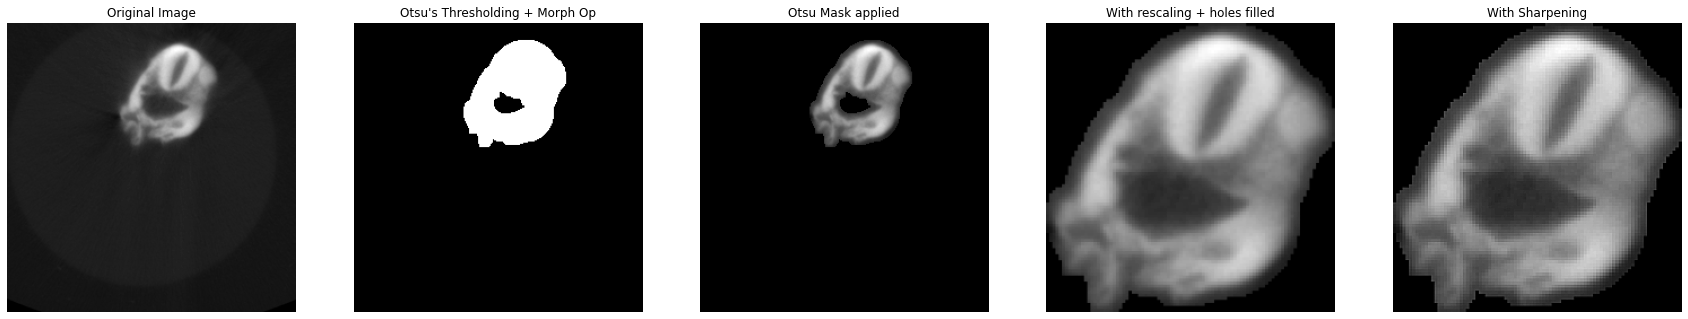

In [63]:
image_name = random.choice(real_image_names)
print(image_name)
real = cv2.imread(os.path.join('../results/ct_hist_test/test_latest/images/', image_name))
# Ensure that 'real' is a grayscale image
# If 'real' is a color image, convert it to grayscale first
if len(real.shape) == 3:
    preproc = cv2.cvtColor(real, cv2.COLOR_BGR2GRAY)
else:
    preproc = real.copy()

# Apply Otsu's threshold
_, binary_image_otsu = cv2.threshold(preproc, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Use dilation to make the regions within the threshold bigger
kernel = np.ones((3,3), np.uint8)
binary_image_otsu = cv2.dilate(binary_image_otsu, kernel, iterations=3)

# Display the original and Otsu thresholded images
fig, ax = plt.subplots(1, 5, figsize=(30, 15))

# Original image
ax[0].imshow(preproc, cmap='gray')
ax[0].title.set_text('Original Image')
ax[0].axis('off')

# Otsu's thresholded image
ax[1].imshow(binary_image_otsu, cmap='gray')
ax[1].title.set_text(f"Otsu's Thresholding + Morph Op")
ax[1].axis('off')

# Apply the threshold to the original image to remove the background
new_img = preproc.copy()
new_img[binary_image_otsu == 0] = 0

# Display the image with the applied threshold
ax[2].imshow(new_img, cmap='gray')
ax[2].title.set_text(f"Otsu Mask applied")
ax[2].axis('off')

# Fill in the largest contour to keep details inside the area of interest
filled_image = fill_largest_contour(preproc, binary_image_otsu)

# Then apply your centering and scaling to the filled image
scaled_new_img = center_and_scale(filled_image, binary_image_otsu)
# Display the image with the applied threshold
ax[3].imshow(scaled_new_img, cmap='gray')
ax[3].title.set_text(f"With rescaling + holes filled")
ax[3].axis('off')

sharp_img = unsharp_mask(scaled_new_img)

ax[4].imshow(sharp_img, cmap='gray')
ax[4].title.set_text(f"With Sharpening")
ax[4].axis('off')


# Show the plot
plt.show()